<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/feature%2F20250203-all-callback-stats-and-actvities/Learning_visualisations_v13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v13: Extending all callbacks for value stats, magnitude stats, and activity stats
I've since realised that:
a) I need to collect magnitude stats in order to produce sensible model-wide plots, and
b) I need to collect activity stats across all data types (layer outputs, layer backprop gradients, variables, variable gradients)

So here I've proving out changes to improve code re-use and standardise how that's all collected. Hopefully also to do it in a somewhat more efficient way.

**TODO**

* Create HistoryStatsCallback to mirror HistoryCallback but return pataframes with percentiles at each epoch, and to also return values per_step if requested.

Timing:
* 36ms/epoch - baseline
* 220ms/epoch - single callback, value stats only (high variance)
* 140ms/epoch - single callback, activity stats only
* 280ms/epoch - single callback, value + activity stats

In [21]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
#!cd repo && git checkout 704ef35
!cd repo && git checkout feature/20250203-all-callback-stats-and-actvities
!cd repo && git pull

import sys
sys.path.append('repo')

import train_observability_toolkit as tot
from importlib import reload
reload(tot)

HEAD is now at f53b1b2 Bug fixes
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 671 bytes | 111.00 KiB/s, done.
From https://github.com/malcolmlett/ml-learning
   f53b1b2..00b483b  feature/20250203-all-callback-stats-and-actvities -> origin/feature/20250203-all-callback-stats-and-actvities
Already on 'feature/20250203-all-callback-stats-and-actvities'
Your branch is behind 'origin/feature/20250203-all-callback-stats-and-actvities' by 1 commit, and can be fast-forwarded.
  (use "git pull" to update your local branch)
Updating f53b1b2..00b483b
Fast-forward
 train_observability_toolkit.py | 28 +++++++++++-----------------
 1 file changed, 11 insertions(+), 17 deletions(-)


<module 'train_observability_toolkit' from '/content/repo/train_observability_toolkit.py'>

In [2]:
import train_observability_toolkit_test
reload(train_observability_toolkit_test)
reload(tot)
train_observability_toolkit_test.run_test_suite()

All train_observability_toolkit tests passed.


In [3]:
import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit
import tqdm

## Basic setup


train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


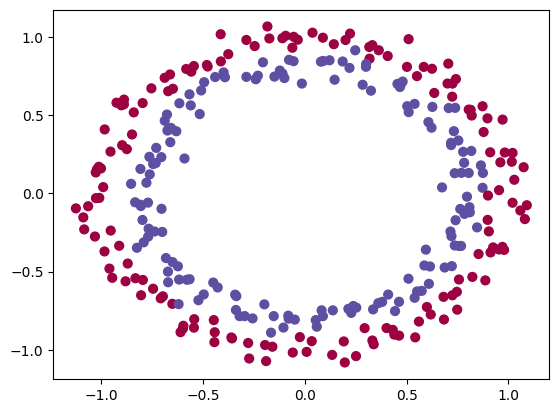

In [4]:
def plot_fit(history = None):
  pnum = 1

  plt.figure(layout='constrained')
  if history != None:
    plt.subplot(1,pnum,1)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
  plt.show()

def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

## Data Collection


In [5]:
reload(tot)
tf.config.run_functions_eagerly(False)

variables = tot.VariableHistoryCallback(per_step=True, value_stats=True, activity_stats=True)
gradients = tot.GradientHistoryCallback(per_step=True)
outputs = tot.LayerOutputHistoryCallback(per_step=True, activity_stats=True)
output_gradients = tot.LayerOutputGradientHistoryCallback(per_step=True, activity_stats=True)
callbacks = [tot.LessVerboseProgressLogger()]
callbacks.append(variables)
callbacks.append(gradients)
callbacks.append(outputs)
callbacks.append(output_gradients)

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history = tot.fit(model, dataset.batch(32), epochs=10, verbose=0, callbacks=callbacks)

Training via custom fit() function. Will produce a few warnings; you can usually ignore these.


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_44']
Received: inputs=Tensor(shape=(32, 2))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_44']
Received: inputs=Tensor(shape=(12, 2))
  warnings.warn(msg)


Epoch     1 - 14.15s/epoch: loss: 0.6920  
Epoch     2 - 547.35ms/epoch: loss: 0.6894  
Epoch     3 - 515.10ms/epoch: loss: 0.6850  
Epoch     4 - 625.89ms/epoch: loss: 0.6806  
Epoch     5 - 626.06ms/epoch: loss: 0.6760  
Epoch     6 - 513.43ms/epoch: loss: 0.6711  
Epoch     7 - 503.83ms/epoch: loss: 0.6669  
Epoch     8 - 625.31ms/epoch: loss: 0.6628  
Epoch     9 - 532.00ms/epoch: loss: 0.6586  
Epoch    10 - 515.39ms/epoch: loss: 0.6542  


In [168]:
def summarise_value_stats(callback):
  print(type(callback).__name__)
  if not callback.value_stats_enabled:
    print(f"value stats disabled")
    return
  print(f"finalised value stats: {len(callback._value_stats)}")
  for i_idx, item_stats in enumerate(callback._value_stats):
    if item_stats is not None:
      print(f"  [{i_idx}]: shape: {item_stats.shape}, mean: {item_stats.mean(axis=0).to_numpy()}")

  print(f"finalised model stats: {type(callback.model_magnitude_stats)}, shape: {callback.model_magnitude_stats.shape}")
  print(f"  mean: {callback.model_magnitude_stats.mean(axis=0).to_numpy()}")

summarise_value_stats(variables)
print()
summarise_value_stats(gradients)
print()
summarise_value_stats(outputs)
print()
summarise_value_stats(output_gradients)

VariableHistoryCallback
finalised value stats: 20
  [0]: shape: (100, 9), mean: [-2.2535887  -1.1958897  -0.68795186 -0.36238575 -0.02219634  0.3699395
  0.73856413  1.0710992   2.085721  ]
  [1]: shape: (100, 9), mean: [-0.02598501 -0.01303877 -0.00851235 -0.00581794 -0.00337903 -0.00012614
  0.00362383  0.00692158  0.01666055]
  [2]: shape: (100, 9), mean: [-3.2769248e-01 -1.7286989e-01 -1.0268020e-01 -4.6998277e-02
  1.4421387e-04  4.7122244e-02  1.0047752e-01  1.7081450e-01
  3.2710975e-01]
  [3]: shape: (100, 9), mean: [-0.02579439 -0.01145697 -0.00733451 -0.00476915 -0.00252533  0.00016687
  0.00379291  0.00814193  0.02204447]
  [5]: shape: (100, 9), mean: [-3.3243752e-01 -1.7228445e-01 -1.0472527e-01 -5.1675621e-02
 -2.6797660e-04  4.6864770e-02  1.0430459e-01  1.7673513e-01
  3.2839942e-01]
  [6]: shape: (100, 9), mean: [-0.02676388 -0.01204829 -0.0085547  -0.00591427 -0.00363503 -0.00023051
  0.00246953  0.00813915  0.02821753]
  [7]: shape: (100, 9), mean: [-0.333562   -0.173

In [169]:
def summarise_activity_stats(callback):
  if not callback.activity_stats_enabled:
    print(f"activity stats disabled")
    return
  print(f"finalised activity stats: {len(callback._activity_stats)}")
  for i_idx, item_stats in enumerate(callback._activity_stats):
    if item_stats is not None:
      print(f"  [{i_idx}]: {type(item_stats)}, shape: {item_stats.shape}, mean: {item_stats.mean(axis=0).to_numpy()}")

  print(f"finalised model stats: {type(callback.model_activity_stats)}, shape: {callback.model_activity_stats.shape}")
  print(f"  mean: {callback.model_activity_stats.mean(axis=0).to_numpy()}")

summarise_activity_stats(variables)
print()
summarise_activity_stats(gradients)
print()
summarise_activity_stats(outputs)
print()
summarise_activity_stats(output_gradients)

finalised activity stats: 20
  [0]: <class 'pandas.core.frame.DataFrame'>, shape: (100, 3), mean: [1. 0. 0.]
  [1]: <class 'pandas.core.frame.DataFrame'>, shape: (100, 3), mean: [1. 0. 0.]
  [2]: <class 'pandas.core.frame.DataFrame'>, shape: (100, 3), mean: [1. 0. 0.]
  [3]: <class 'pandas.core.frame.DataFrame'>, shape: (100, 3), mean: [0.9437998  0.05620001 0.        ]
  [5]: <class 'pandas.core.frame.DataFrame'>, shape: (100, 3), mean: [1. 0. 0.]
  [6]: <class 'pandas.core.frame.DataFrame'>, shape: (100, 3), mean: [0.9026001  0.09740002 0.        ]
  [7]: <class 'pandas.core.frame.DataFrame'>, shape: (100, 3), mean: [1. 0. 0.]
  [8]: <class 'pandas.core.frame.DataFrame'>, shape: (100, 3), mean: [0.87130004 0.12869999 0.        ]
  [10]: <class 'pandas.core.frame.DataFrame'>, shape: (100, 3), mean: [1. 0. 0.]
  [11]: <class 'pandas.core.frame.DataFrame'>, shape: (100, 3), mean: [0.9288 0.0712 0.    ]
  [12]: <class 'pandas.core.frame.DataFrame'>, shape: (100, 3), mean: [1. 0. 0.]
  [1

In [52]:
[(None, None)] * 3

[(None, None), (None, None), (None, None)]

## Plotting

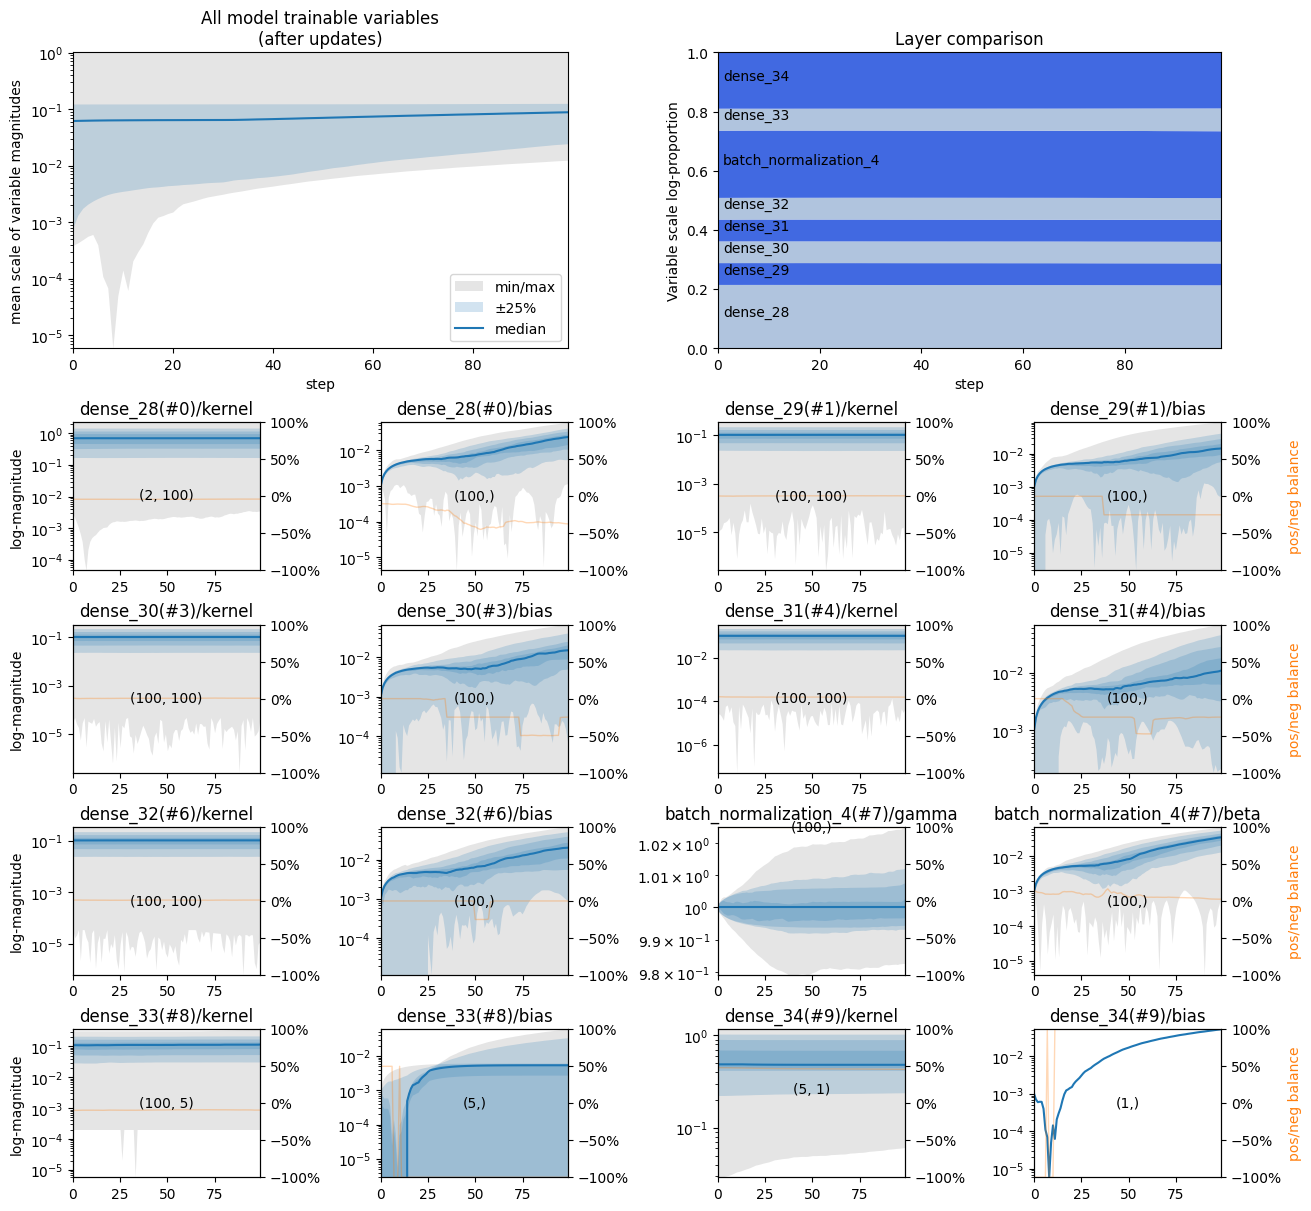

In [61]:
reload(tot)
tot.plot_value_history(variables, magnitudes=True)

## Appendix: Calculating the mid-point of stats


In [155]:
tf.random.set_seed(36)
tensors = [tf.reduce_mean(tf.random.normal((10, 100, 100, 16), mean=m*0.4), axis=0) for m in range(-5, 5)]
a = tf.stack(tensors, axis=0)
print(f"a: {a.shape}")
stats = tfp.stats.percentile(a, q=[0, 25, 50, 75, 100], axis=(1,2,3))
stats = tf.transpose(stats)
stats = pd.DataFrame(stats, columns=[0, 25, 50, 75, 100])
print(stats)
tot.pos_neg_balance(stats.to_numpy())

a: (10, 100, 100, 16)
        0         25        50        75        100
0 -3.502185 -2.213949 -2.000200 -1.788234 -0.593890
1 -2.934851 -1.812864 -1.600239 -1.387483 -0.185881
2 -2.477800 -1.413571 -1.199386 -0.986143  0.185588
3 -2.277014 -1.013918 -0.801460 -0.588015  0.533931
4 -1.764804 -0.612276 -0.399079 -0.184882  0.919897
5 -1.372093 -0.213462  0.000684  0.214422  1.418951
6 -1.037558  0.187456  0.400135  0.613190  1.823436
7 -0.616666  0.585948  0.799512  1.014727  2.138397
8 -0.208241  0.985840  1.198396  1.412850  2.690592
9  0.269208  1.387156  1.600297  1.813392  2.877732


array([-1.        , -1.        , -0.92080616, -0.76205133,  0.36106058,
        0.00159945,  0.61254808,  0.79346176,  0.9128028 ,  1.        ])

In [119]:
pd.to_numeric(stats.columns, errors='raise').to_numpy()

array([  0,  25,  50,  75, 100])

In [89]:
a = np.array([0, 1, 2, 3, 4, 5, 6])
a[-2:]

array([5, 6])

In [95]:
np.polynomial.polynomial.Polynomial.fit([-1, 0, 1], [2, 2, -3], deg=2).roots()

array([-1.52469508,  0.52469508])

In [100]:
np.polynomial.polynomial.Polynomial.fit([-1, 0], [-2, 2], deg=1).roots()

array([-0.5])

## Appendix: Low-level experiments

In [18]:
@tf.function
def compute_percentile_list(variables):
  return [tfp.stats.percentile(variable, [0, 25, 50, 75, 100]) if variable is not None else None for variable in variables]


a = [
    tf.random.normal((32,100,100,16)),
    tf.random.normal((32,50)),
    None,
    tf.random.normal((32,4))
]

compute_percentile_list(a)



[<tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([-5.4443245e+00, -6.7354053e-01,  4.1600000e-04,  6.7484426e-01,
         5.0385928e+00], dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([-3.7848506 , -0.65246487,  0.02417802,  0.7084634 ,  3.2566454 ],
       dtype=float32)>,
 None,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([-2.2118924 , -0.72315234, -0.16991429,  0.58633995,  2.4538276 ],
       dtype=float32)>]

In [13]:
tf.random.set_seed(36)
a = tf.random.normal((32, 100, 100, 16))
a = tf.where(a > 0, a, tf.zeros_like(a))
active_mask = tf.cast(tf.not_equal(a, 0.0), tf.float32)
rate_by_channel = tf.reduce_mean(active_mask, axis=tf.range(tf.rank(active_mask) - 1))
print(f"a: {a.shape}, active_mask: {active_mask.shape}, rate_by_channel: {rate_by_channel.shape}")
print(f"rate_by_channel: {rate_by_channel.numpy()}")

# convert back to counts
num_batches = a.shape[0]
spatial_size = a.shape[1] * a.shape[2]
sum_by_channel = rate_by_channel * num_batches * spatial_size
print(f"sum_by_channel: {sum_by_channel.numpy()}")  # good enough, accurate to within 0.02

dead_by_channel = (1 - rate_by_channel) * num_batches * spatial_size
print(f"dead_by_channel: {dead_by_channel.numpy()}")

a: (32, 100, 100, 16), active_mask: (32, 100, 100, 16), rate_by_channel: (16,)
rate_by_channel: [0.49914375 0.49879375 0.49980626 0.5004875  0.5018375  0.50065315
 0.5010313  0.49911562 0.49996874 0.5008031  0.5002656  0.500225
 0.500025   0.49955    0.49888438 0.5014344 ]
sum_by_channel: [159726.   159614.   159938.   160156.   160588.   160209.   160330.02
 159717.   159990.   160257.   160084.98 160072.   160007.98 159856.
 159643.   160459.  ]
dead_by_channel: [160274.02 160386.02 160061.98 159844.   159412.   159791.   159669.98
 160283.02 160010.   159743.   159915.02 159928.   159992.02 160144.
 160357.   159541.  ]


In [7]:
class MyBase:
  def __init__(self, base_param, shared_param, *args, **kwargs):
    print(f"MyBase init ({base_param=}, {shared_param=})")
    super().__init__(*args, **kwargs, shared_param=shared_param)

class MyMixin:
  def __init__(self, mixin_param, shared_param, *args, **kwargs):
    print(f"MyMixin init ({mixin_param=}, {shared_param=})")
    super().__init__(*args, **kwargs)

class MyConcrete(MyBase, MyMixin):
  def __init__(self, concrete_param, *args, **kwargs):
    print(f"MyConcrete init ({concrete_param=})")
    super().__init__(*args, **kwargs)

c = MyConcrete(1, mixin_param=3, base_param=2, shared_param=5, foo=5)

#print()
#c = MyConcrete(1, 2, 3, 4, 5)


MyConcrete init (concrete_param=1)
MyBase init (base_param=2, shared_param=5)
MyMixin init (mixin_param=3, shared_param=5)


TypeError: object.__init__() takes exactly one argument (the instance to initialize)